In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

In [56]:
# Upload the data
bitcoin = pd.read_csv('./Dataset/bitcoin.csv')
bitcoin.tail()

,Unnamed: 0,close,date,high,low,market_cap,open,volume
1863,1863,105.21,"May 02, 2013",125.60,92.28,"1,292,190,000",116.38,-
1864,1864,116.99,"May 01, 2013",139.89,107.72,"1,542,820,000",139.00,-
1865,1865,139.00,"Apr 30, 2013",146.93,134.05,"1,597,780,000",144.00,-
1866,1866,144.54,"Apr 29, 2013",147.49,134.00,"1,491,160,000",134.44,-
1867,1867,134.21,"Apr 28, 2013",135.98,132.10,"1,500,520,000",135.30,-


In [4]:
# Change the order of dates
bitcoin['Indx'] = np.arange(bitcoin.shape[0]-1, -1, -1)
bitcoin.set_index('Indx', inplace=True)
bitcoin.head()

,Unnamed: 0,close,date,high,low,market_cap,open,volume
Indx,,,,,,,,
1867,0,7624.92,"Jun 08, 2018",7698.19,7558.40,"131,271,000,000",7685.14,"4,227,580,000"
1866,1,7678.24,"Jun 07, 2018",7741.27,7650.82,"130,671,000,000",7650.82,"4,485,800,000"
1865,2,7653.98,"Jun 06, 2018",7680.43,7502.01,"130,233,000,000",7625.97,"4,692,260,000"
1864,3,7633.76,"Jun 05, 2018",7643.23,7397.00,"128,081,000,000",7500.90,"4,961,740,000"
1863,4,7514.47,"Jun 04, 2018",7753.82,7474.04,"131,847,000,000",7722.53,"4,993,170,000"


The column "open" was chosen to analyse.

In [5]:
# Check if the column has missing valueus
bitcoin['open'].isnull().value_counts()

False    1868
Name: open, dtype: int64

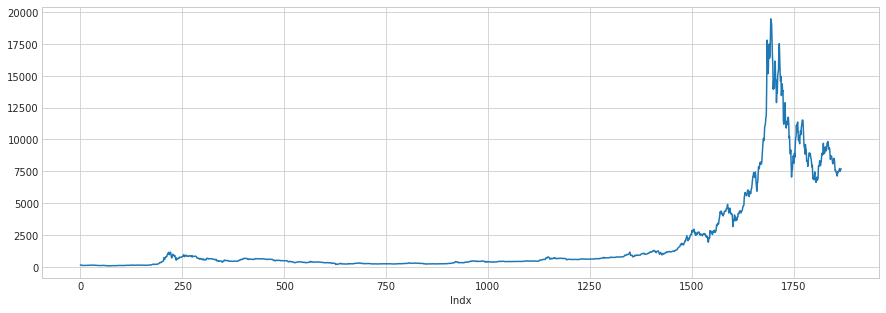

In [6]:
# Vizualisation
fig_size = [15, 5]
_ = bitcoin['open'].plot(figsize = fig_size)

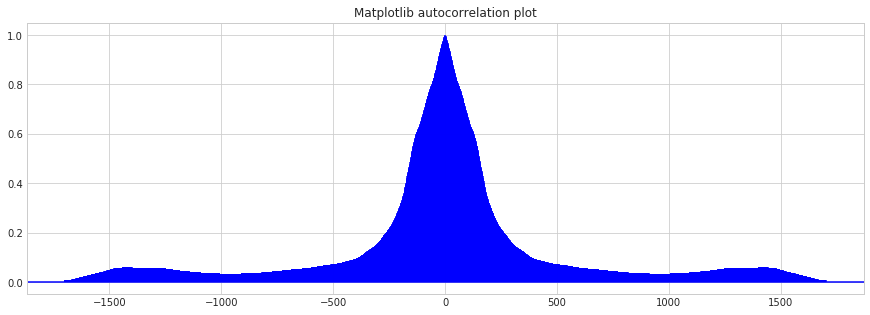

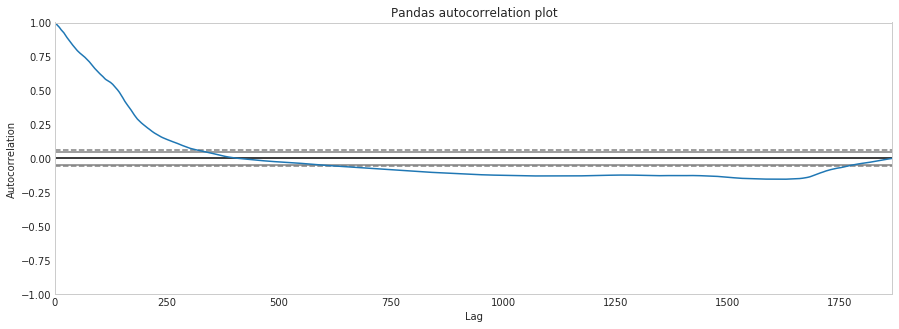

In [7]:
# Autocorrelation function with matplotlib
plt.figure(figsize = fig_size)
_ = plt.acorr(bitcoin['open'],maxlags=1700, color = 'b')
_ = plt.title('Matplotlib autocorrelation plot')

# Autocorrelation function with pandas
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=fig_size)
_ = autocorrelation_plot(bitcoin['open'])
_ = plt.title('Pandas autocorrelation plot')

In [8]:
# Manualy calculated autocorrelation
def my_autocorr(data, lag):
    autocorr = 0
    m = data.mean()
    denominator = 0
    for x in data:
        denominator += (x - m) ** 2
    numerator = 0
    for i in range(lag+1, data.shape[0]):
        numerator += (data[i] - m) * (data[i - lag] - m)
    return numerator / denominator

my_autocorr_list = []
for lag in range(1, bitcoin['open'].shape[0] - 1):
    my_autocorr_list.append(my_autocorr(bitcoin['open'], lag))

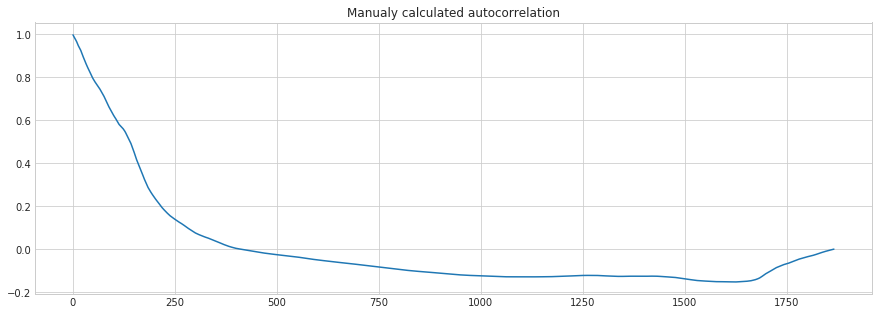

In [9]:
plt.figure(figsize=fig_size)
_ = plt.plot(range(1, bitcoin['open'].shape[0] - 1), my_autocorr_list)
_ = plt.title('Manualy calculated autocorrelation')

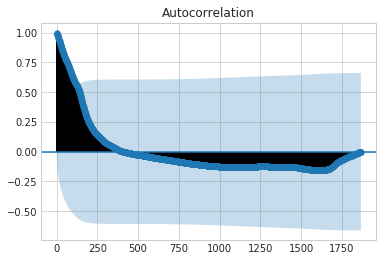

In [10]:
# Autocorrelation function with matplotlib
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bitcoin['open'])
plt.show()

It can be concluded that series is non-stationary because of the form of the autocorrelation function. Also the series has trend. Let's select some part of series to further analysis.

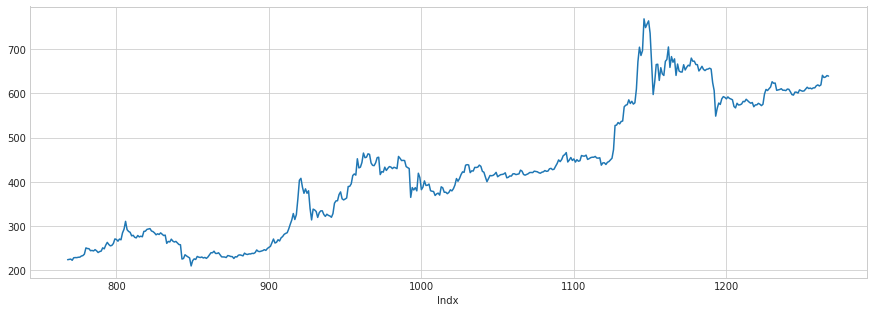

In [26]:
plt.figure(figsize=fig_size)
part_data = bitcoin.iloc[600:1100]['open']
_ = part_data.plot()

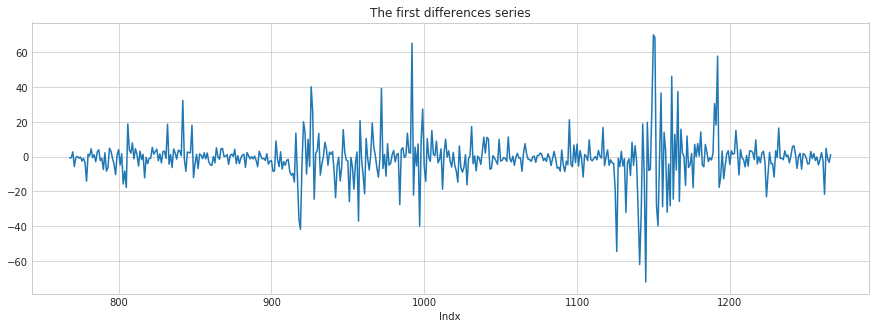

In [27]:
# Use the first differences to remove non-stationary
_ = part_data.diff(periods=1).plot(figsize=fig_size)
_ = plt.title('The first differences series')

In [31]:
diff_series = part_data.diff().dropna()
diff_series = diff_series.reset_index()
diff_series.head()

,Indx,open
0,1266,1.23
1,1265,-3.30
2,1264,-0.98
3,1263,4.84
4,1262,-21.63


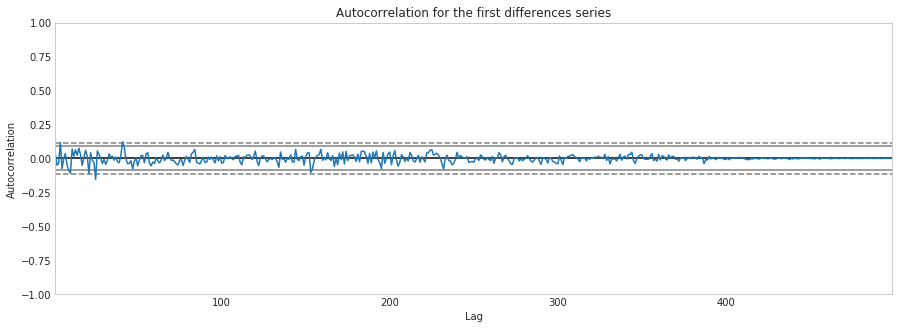

In [40]:
# Plot the autocorrelation function for the series above.
plt.figure(figsize=fig_size)
_ = autocorrelation_plot(diff_series['open'])
_ = plt.title('Autocorrelation for the first differences series')


It can be seen that trend was removed. Now a period can be found. To do that let's find all lags that give values of autocorrelation function that are out of confidence interval. If the number of such lags exceeds 10, a function will returns 10 numbers with the largest absolute values of the autocorrelation function. 

The series has period
Top values of lag:
25
41
4
21
10
153
9


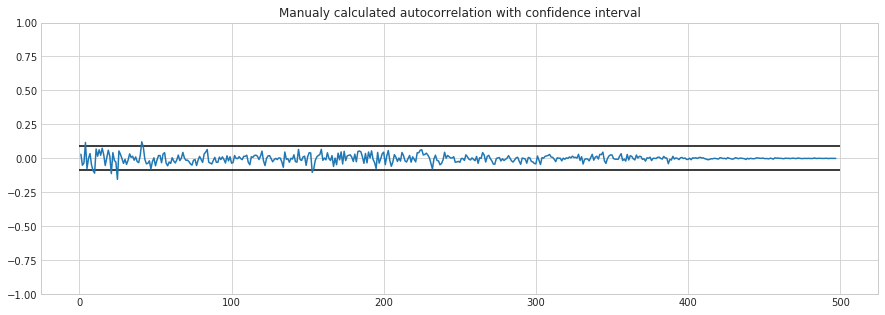

In [54]:
# Check if the series has period and return its value
import math
from scipy.stats import t

def autocorrelation_analysis(initial_series):
    is_period = False
    my_autocorr_dict = {} 
    periods_list = []
    
    for lag in range(1, initial_series.shape[0] - 1):
        my_autocorr_dict[lag] = my_autocorr(initial_series, lag)

    interv = 1.96 / math.sqrt(len(my_autocorr_dict))
    
    for k in my_autocorr_dict.keys():
        if (my_autocorr_dict[k] > interv) | (my_autocorr_dict[k] < (-1) * interv):
            periods_list.append([k, my_autocorr_dict[k]])
    
    periods_list = sorted(list_p, key=lambda x: abs(x[1]), reverse=True)
       
    if (periods_list == []):
        is_period = False
        return is_period, periods_list, my_autocorr_dict, interv
    else:
        is_period = True
        return is_period, periods_list[:10], my_autocorr_dict, interv


bool_p, list_p, dict_autocorr, conf_intv =  autocorrelation_analysis(diff_series['open'])

if bool_p:
    print('The series has period')
    print('Top values of lag:')
    for p in list_p:
        print(p[0])
else:
    print('The series does not have period')


plt.figure(figsize=fig_size)
_ = plt.ylim([-1, 1])
_ = plt.plot(dict_autocorr.keys(), dict_autocorr.values())
_ = plt.hlines(conf_intv, xmin=0, xmax=500)
_ = plt.hlines((-1) * conf_intv, xmin=0, xmax=500)
_ = plt.title('Manualy calculated autocorrelation with confidence interval')
    

Also let's calculate the partial autocorelation fucnction

/home/khrystyna/.local/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


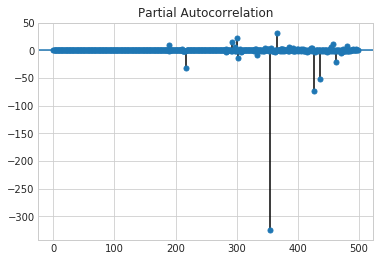

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff_series['open'])
plt.show()

Question: I cannot understand the range of values pacf. Could you please explain?